# Getting to cross-sections

In [1]:
import uproot
from array import array
import numpy as np
import multiprocessing, time, uuid, tempfile
import sys, math, os, subprocess, csv, hist
from ROOT import TFile, TTree, TGraph2DErrors, TH1F, gROOT, TMath
import matplotlib.pyplot as plt
import awkward as ak
import ROOT as r
from scipy.interpolate import griddata

os.environ['MPLCONFIGDIR'] = tempfile.mkdtemp()
sys.path.insert(0, 'python/')

Welcome to JupyROOT 6.28/04


Total entries in data histogram 349270.0
prod_scale 8.019473751969585e-05
Average charge symmetric background electrons 0.02836125377102955
Implicit multithreading is enabled, using 8 cores.
hsdelta_binwidth: 0.5
hytar_binwidth: 0.08
hsyptar_binwidth: 0.001
hsxptar_binwidth: 0.002
Total entries in simulation histogram 6205770
mc_scale 7.473771304999999e-08
Bins in data histogram 36
Bins in simulation histogram 36


/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_2545/19347505.py:336: RuntimeWarning: divide by zero encountered in divide
  ratio_delta = deltacorrected_bin_contents/bin_counts
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_2545/19347505.py:337: RuntimeWarning: invalid value encountered in divide
  ratio_errors = ratio_delta*np.sqrt((subtracted_bin_errors/subtracted_bin_contents)**2 + (bin_errors/bin_counts)**2)
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_2545/19347505.py:339: RuntimeWarning: divide by zero encountered in divide
  raw_ratio_delta = raw_bin_contents/bin_counts
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_2545/19347505.py:340: RuntimeWarning: invalid value encountered in divide
  raw_ratio_errors = raw_ratio_delta*np.sqrt((raw_bin_errors/raw_bin_contents)**2 + (bin_errors/bin_counts)**2)


The program took 0.23 minutes to run


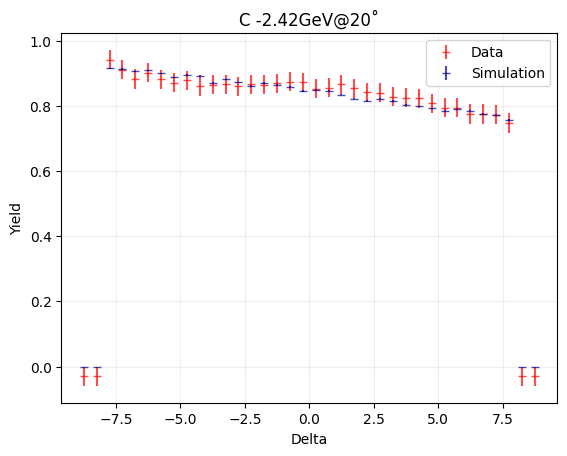

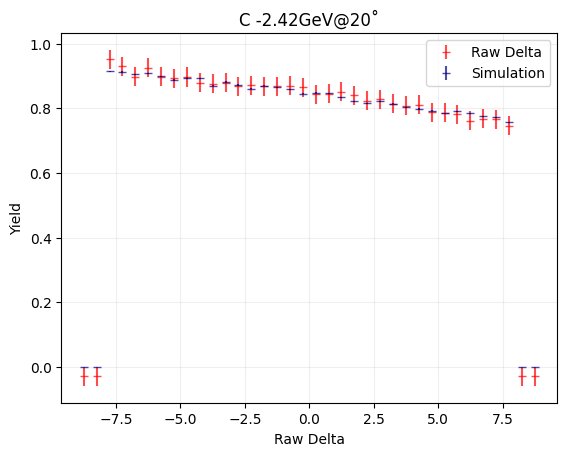

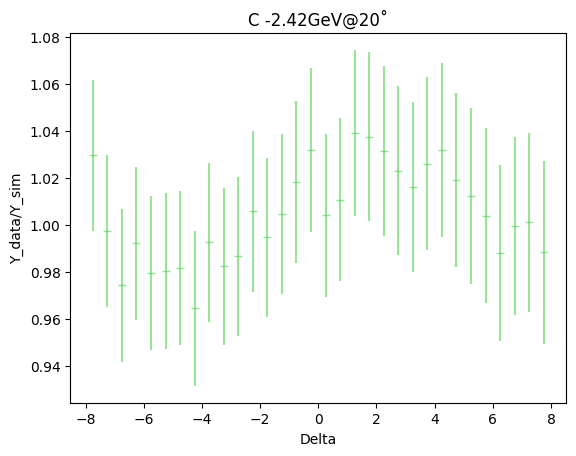

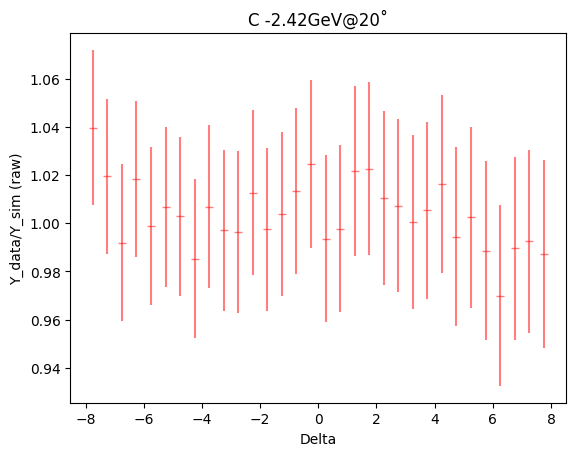

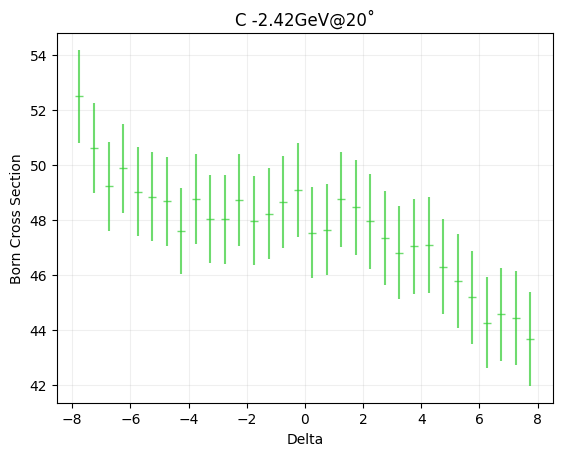

In [31]:
start_time = time.time()
r.EnableImplicitMT()

dtg = 'C12' #What is your desired target?
dang = 20.0 #What is your desired angle?
dmom = 2.42 #What is your desired momentum
string = str(dmom).replace('-', '').replace('.', 'p').rstrip('0')
cafe_report_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/'
tinfo_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/HMS_runlist copy.txt'
runlist_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/file.txt'
datafile_path = '/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/'
bin_num = 36 #half percent bins according to the resolution of the spectrometer(-8% to 8%)

def csb(eprime):
    if dang == 20.0:
        targ = ['C12', 'Ca40', 'Ag', 'Al', 'Au', 'Be', 'B10', 'B11', 'Ca48', 'Cu', 'LD2', 'Dummy', 'Fe54', 'He3', 'He4', 'Li6', 'Li7', 'Ni58', 'Ni64', 'Sn*', 'Th', 'Ti']
        a_list = [1.766, 2.129, 1.904, 1.717, 1.789, 1.974, 1.798, 1.833, 2.218, 2.157, 2.763, 1.642, 1.723, 2.338, 2.307, 1.741, 1.845, 1.415, 1.423, None, 1.814, 1.600]
        b_list = [-2.185, -2.064, -1.951, -2.130, -1.938, -2.231, -2.206, -2.218, -2.036, -1.964, -2.423, -2.130, -2.072, -2.348, -2.278, -2.247, -2.311, -2.034, -2.037, None, -1.927, -2.103]
    if dang == 26.0:
        targ = ['C12', 'Ca40', 'LD2', 'Dummy']
        a_list = [2.244, 2.355, 3.324, 2.079]
        b_list = [-2.637, -2.338, -3.045, -2.538]
    if dang == 35.0:
        targ = ["C12", "Ca40", "Ca48", "LD2", "Dummy", "He3", "He4"]
        a_list = [2.286, 1.977, 1.917, 3.091, 2.126, 2.674, 2.627]
        b_list = [-2.935, -2.275, -2.183, -3.451, -2.778, -3.246, -3.120]
    if dtg in targ:
        i = targ.index(dtg)
        a_pow = a_list[i]
        b_pow = b_list[i]
    else:
        print("Target not found")
    csb = np.exp(a_pow + b_pow*eprime)
    return csb

rk = []
# Function to read the text file into an array
def ImportRadcor(filename):
    vectors = [[] for _ in range(13)]
    with open(filename, 'r') as infile:
        for line in infile:
            values = line.split()
            if len(values) == 13:
                for i, val in enumerate(values):
                    vectors[i].append(float(val))
    return [np.array(v) for v in vectors]

#Function to calculate scaling factors for data
def read_report():
    q = j = 0
    ls = '2'
    sf = []
    runlist_file = open(runlist_path)
    for line in runlist_file:
        rrr = int((line.split("\n")[0]).strip())
        rk.append(rrr)
        #This for loop reads from the HMS_runlist file
        tinfo_file = open(tinfo_path, "r")
        for line in tinfo_file:
            sline = line.split('\t')
            try:
                tg = sline[3]
                mom = sline[4]
                angle = sline[5]
                rrr2 = int(sline[0])
                #print(rrr2)
            except:
                continue
            if j == 0:
                continue
        tinfo_file.close()
        cafe_report = open(cafe_report_path+"replay_hms_production_%d_-1.report"%rrr)
        for line in cafe_report:
            if "BCM4A Beam Cut Charge" in line:
                c2 = float((line.split(":")[1]).strip()[:-2])
                #print("c2:",c2)
            if "_factor" in line:
                f1 = float((line.split("=")[-1].strip()))
                if f1 != -1.0 :
                    #print("Prescale factor:",f1)
                    ll = f1
                    f2 = str((line.split(["="][0])))
                    ls = f2[4]
                    #print("Active trigger",f2[4])
                    continue
                #print("Chalega to dikhega",clt)
            if "Ps%s HMS Computer Live Time"%ls in line:
                clt= float((line.split(":")[1]).strip()[:-3])
            if "BCM4A Beam Cut Current" in line:
                cc = float((line.split(":")[1]).strip()[:-2])
            if "E SING FID" in line:
                fid = float((line.split(":")[1]).strip()[:-11])
                c2o = c2*(1 + 0.37/cc) #Beam current offset correction
                pro = c2o*clt*0.01
                #print("pro",pro,rrr)
                #print("fid",fid)
                pro2 = pro*fid #Denominator for the CNY
                #print("Pre-scale factor ",ll)
                #print("Denominator:",pro2)
                sf.append(pro2/ll) #Saving the scaling factors into a list
                j=j+1
                q=q+1
    tsf = sum(sf)
    p_scale = 1/tsf
    return p_scale

def koshish5():
    #Kinematic variables
    ts = dang #Spectrometer angle
    p_spec = dmom #Just the magnitude
    Z, A = 6, 12  #Target
    density = 1.0 #Target density g/cm3
    thick = 0.574 #g/cm2. From Cameron's target sheet column 'R'

    #Constants
    Ei, Mp = 10.54, 0.93825 #Beam energy and proton mass in GeV
    N_A, Q_E = 6.02e+23, 1.60e-19 #Avogadro's number and charge in 1 electron
    al_den, length = 2.699, 10. #Density of aluminum can and length of can
    dpp_up, dpp_down = 15.0, -15.0 #Momentum acceptance upper and lower limit
    cos_ts = np.cos(np.deg2rad(ts))
    sin_ts = np.sin(np.deg2rad(ts))
    ep_min = p_spec * (1 + 0.01 * dpp_down)
    ep_max = p_spec * (1 + 0.01 * dpp_up)
    phi_up, phi_down, theta_up, theta_down = 110.0, -110.0, 65.0, -65.0 #mrad
    domega = (phi_up - phi_down) * (theta_up - theta_down) / 1e6  #diff solid angle in sr
    sim_charge = 1.
    wall_exit, wall_ent = 0.0168, 0.02024 #in cm
    dum_thick_exit, dum_thick_ent = 0.1816, 0.1815 #g/cm2
    hyd_thick_ent = al_den * wall_ent #g/cm2
    hyd_thick_exit = al_den * wall_exit #g/cm2
    lumin = thick * sim_charge / A * N_A / Q_E * 1e-39
    ratio_ent = hyd_thick_ent / dum_thick_ent
    ratio_exit = hyd_thick_exit / dum_thick_exit
    #prod_scale = ps_factor / charge*clt*eff
    prod_scale = read_report()

    ################################################################################### DATA WORK #########################################################################################
    
    #Define the data cuts
    data_cut = "-7.9064 < H.gtr.dp && H.gtr.dp < 8.1247 && H.cal.etottracknorm > 0.7 && abs(H.gtr.ph) < 0.032 && abs(H.gtr.th) < 0.085 && H.cer.npeSum > 2 && H.bcm.CurrentFlag == 1"
    delta_cut = "-8 < H.gtr.dp && H.gtr.dp < 8 && H.cal.etottracknorm > 0.7 && abs(H.gtr.ph) < 0.032 && abs(H.gtr.th) < 0.085 && H.cer.npeSum > 2 && H.bcm.CurrentFlag == 1"

    #Create a TChain
    ch = r.TChain("T")
    for run in rk:
        ch.Add(f'/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/hms_replay_production_{run}_-1.root')
    df = r.RDataFrame(ch)  #Create an RDataFrame from the TChain
    
    #Apply the cuts to the chained dataframe
    hc = df.Filter(data_cut)\
           .Define("corr_delta", "H.gtr.dp + (0.991333*H.gtr.dp - 0.0026865*H.gtr.dp*H.gtr.dp + 0.00023225*H.gtr.dp*H.gtr.dp*H.gtr.dp + 0.00001006*H.gtr.dp*H.gtr.dp*H.gtr.dp*H.gtr.dp - 1.96515e-6*H.gtr.dp*H.gtr.dp*H.gtr.dp*H.gtr.dp*H.gtr.dp + 8.42355e-8*H.gtr.dp*H.gtr.dp*H.gtr.dp*H.gtr.dp*H.gtr.dp*H.gtr.dp - H.gtr.dp)")\
           .Define("Eprime", "2.42*(1 + 0.01*corr_delta)")
    
    hd = df.Filter(delta_cut)
    
    #Create the histograms from the dataframe
    hdeltadat = hc.Histo1D(("CNY vs Delta", "CNY vs Delta", bin_num, -9.0, 9.0),"corr_delta")
    hdeltadat.Sumw2()
    hdeltaraw = hd.Histo1D(("CNY vs Delta", "CNY vs Delta", bin_num, -9.0, 9.0),"H.gtr.dp")
    hdeltaraw.Sumw2()
    hytardat = hc.Histo1D(("ytar data", "ytar data", 100, -4, 4),"H.gtr.y")
    hytardat.Sumw2()
    hyptardat = hc.Histo1D(("yptar data", "yptar data", 100, -0.05, 0.05),"H.gtr.ph")
    hyptardat.Sumw2()
    hxptardat = hc.Histo1D(("xptar data", "xptar data", 100, -0.1, 0.1),"H.gtr.th")
    hxptardat.Sumw2()
    print("Total entries in data histogram", hdeltadat.GetEntries())
    
    hdeltadat.Scale(prod_scale) # Scale the data histograms by prod_scale
    hytardat.Scale(prod_scale)
    hyptardat.Scale(prod_scale)
    hxptardat.Scale(prod_scale)
    hdeltaraw.Scale(prod_scale)
    print("prod_scale", prod_scale)
    #print(type(hdeltadat),"hdeltadat type")

    def root_hist_to_numpy(root_hist):
        bin_edges = np.array([root_hist.GetXaxis().GetBinLowEdge(i) for i in range(1, root_hist.GetNbinsX() + 2)])
        bin_contents = np.array([root_hist.GetBinContent(i) for i in range(1, root_hist.GetNbinsX() + 1)])
        bin_errors = np.array([root_hist.GetBinError(i) for i in range(1, root_hist.GetNbinsX() + 1)])
        #Apply Delta correction

        # Extract data from the TH1D object
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        return bin_centers, bin_contents, bin_errors

    #fig refers to the entire canvas on which plots are drawn. ax refers to a single plot/subplot
    fig, ax = plt.subplots()

    filtered_bin_centers, filtered_bin_contents, filtered_bin_errors = root_hist_to_numpy(hdeltadat)
    raw_bin_centers, raw_bin_contents, raw_bin_errors = root_hist_to_numpy(hdeltaraw)

    #Perform charge symmetric background subtraction
    eprime_contents = p_spec*(1 + 0.01*filtered_bin_contents)
    csb_contents = csb(eprime_contents)
    #print("Length of csb", len(csb_contents))
    print("Average charge symmetric background electrons", np.mean(csb_contents))
    subtracted_bin_contents = filtered_bin_contents - csb_contents
    subtracted_bin_errors = np.sqrt(filtered_bin_errors**2 + csb_contents**2)
    raw_bin_contents = raw_bin_contents - csb_contents
    raw_bin_errors = np.sqrt(raw_bin_errors**2 + csb_contents**2)

    deltacorrected_bin_contents = subtracted_bin_contents

    ax.errorbar(filtered_bin_centers, deltacorrected_bin_contents, yerr = subtracted_bin_errors, fmt = '_', color = 'red', alpha = 0.7, label = 'Data')
    ax.grid(True, alpha = 0.2)
    ax.set_xlabel('Delta')

    fig3, ax3 = plt.subplots()
    ax3.errorbar(raw_bin_centers, raw_bin_contents, yerr = raw_bin_errors, fmt = '_', color = 'red', alpha = 0.7, label = 'Raw Delta')
    ax3.grid(True, alpha = 0.2)
    ax3.set_xlabel('Raw Delta')

    # Check if IMT is enabled
    if r.IsImplicitMTEnabled():
        nthreads = r.ROOT.GetThreadPoolSize()
        print(f"Implicit multithreading is enabled, using {nthreads} cores.")
    else:
        print("Implicit MT is not enabled.")

    ###########################################################################################      SIMULATION WORK     ########################################################################

    #Read the Cross-section table
    V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13 = ImportRadcor("/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/xem2/xem2_20degcarbon22_hms.out")
    size = len(V1)

    filepath = "/Users/AbSir/Library/CloudStorage/GoogleDrive-asharda@vols.utk.edu/My Drive/hms_mc_c_20degm2p42.root"

    # Open the file and tree
    file = uproot.open(filepath)
    tree = file["h1"]

    # Load the branches
    electrons = tree.arrays(["hsdelta", "hsytar", "hsyptar", "hsxptar", "stop_id"], library='np')    
    nentries = len(electrons["hsdelta"])
    #print("nentries", nentries)

    # Apply the cuts
    mc_cut = (np.abs(electrons["hsdelta"]) < 8) & \
             (np.abs(electrons["hsyptar"]) < 0.032) & \
             (np.abs(electrons["hsxptar"]) < 0.085) & \
             (electrons["stop_id"] == 0)

    # Filter 'hsdelta' with the cuts
    hsdelta_cut = electrons["hsdelta"][mc_cut]
    hsyptar_cut = electrons["hsyptar"][mc_cut]
    hsxptar_cut = electrons["hsxptar"][mc_cut]
    hytar_cut = electrons["hsytar"][mc_cut]

    # Calculate E' and theta(in degrees)
    Eprime = p_spec*(1 + 0.01*hsdelta_cut)
    thetarad = np.arccos((cos_ts + hsyptar_cut*sin_ts)/np.sqrt(1 + hsxptar_cut*hsxptar_cut + hsyptar_cut*hsyptar_cut))
    thetadeg = np.rad2deg(thetarad)
    # print("Size of Eprime", len(Eprime))
    # print("Size of thetadeg", len(thetadeg))
    
    # Perform the interpolation
    points = np.array([V2, V3]).T #Make a 2D array and transpose it so each array is of the form [E',theta]
    points_to_interpolate = np.column_stack((Eprime, thetadeg))
    xsec_array = griddata(points, V9, points_to_interpolate, method='linear') #Specify the 2D array of [E's, thetas] as first argument; Radiative cross-section(V9) as the z-axis and (Ep, theta) as the point for which we need the cross-section

    # Calculate the scale for simulation
    mc_scale = lumin * domega * (ep_max - ep_min) / nentries

    #Fixing the binning for the data histograms
    hsdelta_min = -9.0
    hsdelta_max = 9.0
    hsdelta_num_bins = bin_num
    hytar_min = -4.0
    hytar_max = 4.0
    hytar_num_bins = 100
    hsyptar_min = -0.05
    hsyptar_max = 0.05
    hsyptar_num_bins = 100
    hsxptar_min = -0.1
    hsxptar_max = 0.1
    hsxptar_num_bins = 100
    hsdelta_binwidth = (hsdelta_max - hsdelta_min) / hsdelta_num_bins
    hytar_binwidth = (hytar_max - hytar_min) / hytar_num_bins
    hsyptar_binwidth = (hsyptar_max - hsyptar_min) / hsyptar_num_bins
    hsxptar_binwidth = (hsxptar_max - hsxptar_min) / hsxptar_num_bins
    hsdelta_binedges = np.arange(hsdelta_min, hsdelta_max + hsdelta_binwidth, hsdelta_binwidth)
    hytar_binedges = np.arange(hytar_min, hytar_max + hytar_binwidth, hytar_binwidth)
    hsyptar_binedges = np.arange(hsyptar_min, hsyptar_max + hsyptar_binwidth, hsyptar_binwidth)
    hsxptar_binedges = np.arange(hsxptar_min, hsxptar_max + hsxptar_binwidth, hsxptar_binwidth)
    print("hsdelta_binwidth:", hsdelta_binwidth)
    print("hytar_binwidth:", hytar_binwidth)
    print("hsyptar_binwidth:", hsyptar_binwidth)
    print("hsxptar_binwidth:", hsxptar_binwidth)

    #This function returns 2 arrays: bin counts(the counts in each bin taking weights into account) and bin edges(The edges of the bins)
    #This array has 1 more element than bin_counts because it defines the boundaries between bins
    bin_counts, bin_edges = np.histogram(hsdelta_cut, weights = xsec_array*mc_scale, bins = hsdelta_binedges)
    bin_counts2, bin_edges2 = np.histogram(hytar_cut, weights = xsec_array*mc_scale, bins = hytar_binedges)
    bin_counts3, bin_edges3 = np.histogram(hsyptar_cut, weights = xsec_array*mc_scale, bins = hsyptar_binedges)
    bin_counts4, bin_edges4 = np.histogram(hsxptar_cut, weights = xsec_array*mc_scale, bins = hsxptar_binedges)
    #bin_sqares contains the square of the error for each bin
    bin_squares, _ = np.histogram(hsdelta_cut, weights = (xsec_array*mc_scale)**2, bins = hsdelta_binedges)
    bin_squares2, _ = np.histogram(hytar_cut, weights = (xsec_array*mc_scale)**2, bins = hytar_binedges)
    bin_squares3, _ = np.histogram(hsyptar_cut, weights = (xsec_array*mc_scale)**2, bins = hsyptar_binedges)
    bin_squares4, _ = np.histogram(hsxptar_cut, weights = (xsec_array*mc_scale)**2, bins = hsxptar_binedges)
    #Calculating the actual error for each bin
    bin_errors = np.sqrt(bin_squares)
    bin_errors2 = np.sqrt(bin_squares2)
    bin_errors3 = np.sqrt(bin_squares3)
    bin_errors4 = np.sqrt(bin_squares4)
    #The bin centers are calculated for plotting purposes. bin_edges[:-1] is all bin edges except the last, and bin_edges[1:] is all bin edges except the first.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2
    bin_centers3 = (bin_edges3[:-1] + bin_edges3[1:]) / 2
    bin_centers4 = (bin_edges4[:-1] + bin_edges4[1:]) / 2

    #Plotting the histogram with error bars
    ax.errorbar(bin_centers, bin_counts, yerr = bin_errors, fmt='_', color = 'darkblue', alpha = 0.7, label = 'Simulation')
    ax.set_xlabel('Delta')
    ax.set_ylabel('Yield')
    ax.set_title('C -2.42GeV@20˚')
    ax.legend()
    ax.grid(True, alpha = 0.2)
    fig.savefig('uprootDelta.png')

    ax3.errorbar(bin_centers, bin_counts, yerr = bin_errors, fmt='_', color = 'darkblue', alpha = 0.7, label = 'Simulation')
    ax3.set_xlabel('Raw Delta')
    ax3.set_ylabel('Yield')
    ax3.set_title('C -2.42GeV@20˚')
    ax3.legend()
    ax3.grid(True, alpha = 0.2)
    fig3.savefig('uprootRawDelta.png')
    
    print("Total entries in simulation histogram", len(hsdelta_cut))
    print("mc_scale", mc_scale)

    print("Bins in data histogram", len(filtered_bin_contents))
    print("Bins in simulation histogram", len(bin_counts))
    
    ratio_delta = deltacorrected_bin_contents/bin_counts
    ratio_errors = ratio_delta*np.sqrt((subtracted_bin_errors/subtracted_bin_contents) + (bin_errors/bin_counts))

    raw_ratio_delta = raw_bin_contents/bin_counts
    raw_ratio_errors = raw_ratio_delta*np.sqrt((raw_bin_errors/raw_bin_contents)**2 + (bin_errors/bin_counts)**2)

    # print("Length of xsec_delta", len(xsec_delta))
    # print("Length of born_xsec_array", len(born_xsec_array))
    # bxs_bin_counts, bxs_bin_edges = np.histogram(xsec_delta, weights = born_xsec_array, bins = hsdelta_binedges)
    # bxs_bin_centers = (bxs_bin_edges[:-1] + bxs_bin_edges[1:]) / 2
    fig2, ax2 = plt.subplots()
    ax2.errorbar(bin_centers, ratio_delta, yerr = ratio_errors, fmt = '_', alpha = 0.5, color = 'limegreen', label = 'Delta corrected')
    ax2.set_xlabel('Delta')
    ax2.set_ylabel('Y_data/Y_sim')
    ax2.set_title('C -2.42GeV@20˚')

    fig4, ax4 = plt.subplots()
    ax4.errorbar(bin_centers, raw_ratio_delta, yerr = raw_ratio_errors, fmt = '_', color = 'red', alpha = 0.5, label = 'Delta uncorrected')
    ax4.set_xlabel('Delta')
    ax4.set_ylabel('Y_data/Y_sim (raw)')
    ax4.set_title('C -2.42GeV@20˚')
    fig4.savefig('Data2mc.png')

    delta_array = np.zeros(bin_num)
    for b in range(bin_num):
        delta_array[b] = -7.75 + 0.5*b
    #print("delta_array", delta_array)
    eprime_array = p_spec*(1 + 0.01*delta_array)

    points_to_interpolate2 = np.column_stack((eprime_array, np.full(len(eprime_array), 20)))
    born_xsec_array = griddata(points, V6, points_to_interpolate2, method='linear')
    # print("Length of born_xsec_array", len(born_xsec_array))

    fig5, ax5 = plt.subplots()
    born_cross = ratio_delta * born_xsec_array
    # print("Length of born_cross", len(born_cross))
    # print("Born cross section", born_cross)
    born_errors = born_cross * ratio_errors
    ax5.errorbar(bin_centers, born_cross, yerr = born_errors, fmt = '_', color = 'limegreen', alpha = 0.7, label = 'Weighted cross-section')
    ax5.set_xlabel('Delta')
    ax5.set_ylabel('Born Cross Section')
    ax5.set_title('C -2.42GeV@20˚')
    #ax5.legend()
    ax5.grid(True, alpha = 0.2)
    fig5.savefig('uprootxsec.png')

if __name__ == "__main__":
    koshish5()
    end_time = time.time()
    duration = end_time - start_time
    minutes = duration/60
    print(f"The program took {minutes:.2f} minutes to run")

\begin{equation}
    \sigma^{Born}_{data} = \frac{Y_{data}}{Y_{MC}} \cdot \sigma^{Born}_{MC}
\end{equation}

In [17]:
import random
x = 8.13
y = x + (0.991333 * x - 0.0026865 * x**2 + 0.00023225 * x**3 + 0.00001006 * x**4 - 1.96515e-6 * x**5 + 8.42355e-8 * x**6 - x) - 8
print(y)

0.005247084664162571


In [22]:
from scipy.optimize import fsolve

# Define the function that represents the left side of the equation
def func(x):
    return x + (0.991333 * x - 0.0026865 * x**2 + 0.00023225 * x**3 + 0.00001006 * x**4 - 1.96515e-6 * x**5 + 8.42355e-8 * x**6 - x) + 8

# Use fsolve to find the root, with an initial guess of x0
x0 = 0
x_solution = fsolve(func, x0)

# Print the solution
print(x_solution[0])

-7.9064030383260056


-7.9064030383260056 - 8.124701743136056